In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [40]:
def Euler1D(Q, γ, Δx, CFL, FinalTime, BoundaryCondition):
    
    fig = plt.figure(1, constrained_layout=True,figsize=(6,6))
    ax = fig.add_subplot(1,1,1);
    #ax.set_ylim(0,1);
    #ax.set_xlim(0,1);
    line1=ax.plot(x,Q[:,0])
    hfig = display(fig, display_id=True)
    
    Time = 0.0
    while Time < FinalTime:
        Δt = CFL*Δx/MaximumEigenvalue(Q, γ)
        if Δt > (FinalTime - Time):
            Δt = FinalTime - Time;

        # 3rd order TVD Runge-Kutta scheme
        Q1 =    Q        -   Δt * FluxDerivative(Q, γ, Δx, BoundaryCondition)
        Q2 = (3*Q +   Q1 -   Δt * FluxDerivative(Q1, γ, Δx, BoundaryCondition))/4
        Q  = (  Q + 2*Q2 - 2*Δt * FluxDerivative(Q2, γ, Δx, BoundaryCondition))/3

        Time += Δt;
        #print(Time)
        line1[0].set_ydata(Q[:,0])
        fig.canvas.draw()
        hfig.update(fig)
    return Q

In [41]:
def FluxDerivative(Q, γ, Δx, BoundaryCondition):
    Ord = 5 # The order of the scheme
    Q = BoundaryCondition(Q)

    N = Q.shape[0]
    F_half = np.zeros([N-Ord, 3])
    G_half = np.zeros([1, 3])
    #Qi = np.zeros([Ord+1, 3])

    M = MaximumEigenvalue(Q, γ)

    for i in range(N-Ord):
        #Qi[1:Ord+1, 1:3] = Q[i:i+Ord, 1:3]
        Qi = Q[i:i+Ord+1,:]
        Λ = Eigenvalues(Qi, γ)

        Qa = Average(Qi)
        R, L = Eigensystem(Qa, γ)

        W = np.matmul(Qi,L)       # Transforms into characteristic variables
        G = Λ*W       # The flux for the characteristic variables is Λ * L*Q
        for j in range(3):    # WENO reconstruction of the flux G
            G_half[:,j] = ReconstructedFlux(G[:,j], W[:,j], M)

        F_half[i,:] = np.matmul(G_half,R) # Brings back to conservative variables

    return (F_half[1:,:] - F_half[:-1,:])/Δx # Derivative of Flux

In [42]:
def Average(Q):
    r = 2
    return (Q[r,:] + Q[r+1,:])/2;

def Pressure_1d(Q, γ):
    return (γ-1)*(Q[2] - Q[1]**2 / Q[0]/2)

def Pressure_2d(Q, γ):
    return (γ-1)*(Q[:,2] - Q[:,1]**2 / Q[:,0]/2)

In [43]:
def Eigensystem(Q, γ):
    U = Q[1]/Q[0]
    P = Pressure_1d(Q, γ)
    A = np.sqrt(γ*P/Q[0]) # Sound speed
    H = (Q[2] + P)/Q[0]    # Enthalpy
    h = 1/(2*H - U**2)

    R = np.asarray(
        [[1,U - A,H - U*A],
         [1,U    ,U**2/2],
         [1,U + A,H + U*A]]
    )

    L = np.asarray(
        [[U/(2*A) + U**2*h/2,2 - (2*H)*h,U**2*h/2 - U/(2*A)],
         [-U*h - 1/(2*A)   ,(2*U)*h    ,1/(2*A) - U*h],
         [h                ,-2*h       ,h]]
    )
    return R, L

In [44]:
def Eigenvalues(Q, γ):
    U = Q[:,1]/Q[:,0]
    P = Pressure_2d(Q, γ)
    A = np.sqrt(γ*P/Q[:,0])

    return np.stack([U-A, U, U+A],axis=1)

def MaximumEigenvalue(Q, γ):
    return np.max(np.abs(Eigenvalues(Q, γ)))

In [45]:
def ReconstructedFlux(F, Q, M):
    F_plus  = (F + M*Q)/2
    F_minus = (F - M*Q)/2

    F_half_plus  = WenoZ5ReconstructionLTR(F_plus)
    F_half_minus = WenoZ5ReconstructionLTR(np.flip(F_minus,axis=0))

    return F_half_plus + F_half_minus

In [46]:
def WenoZ5ReconstructionLTR(Q):
    # Constante para 
    ɛ = 1e-40
    
    u1, u2, u3, u4, u5=Q[:-1]
    
    # Calcula os indicadores de suavidade locais
    β0 = ( 1/2.0*u1 - 2*u2 + 3/2.0*u3)**2 + 13/12.0*(u1 - 2*u2 + u3)**2
    β1 = (-1/2.0*u2        + 1/2.0*u4)**2 + 13/12.0*(u2 - 2*u3 + u4)**2
    β2 = (-3/2.0*u3 + 2*u4 - 1/2.0*u5)**2 + 13/12.0*(u3 - 2*u4 + u5)**2
    
    # Calcula o indicador de suavidade global
    τ = np.abs(β0 - β2)
    
    # Calcula os pesos do WENO-Z
    α0 = (1/10) * (1 + (τ/(β0 + ɛ))**2)
    α1 = (6/10) * (1 + (τ/(β1 + ɛ))**2)
    α2 = (3/10) * (1 + (τ/(β2 + ɛ))**2)
    soma = α0 + α1 + α2
    ω0 = α0 / soma
    ω1 = α1 / soma
    ω2 = α2 / soma
    
    # Calcula os fhat em cada subestêncil
    fhat0 = (2*u1 - 7*u2 + 11*u3)/6
    fhat1 = ( -u2 + 5*u3 +  2*u4)/6
    fhat2 = (2*u3 + 5*u4 -    u5)/6
    
    # Calcula o fhat do estêncil todo
    fhat = ω0*fhat0 + ω1*fhat1 + ω2*fhat2
    return fhat


In [47]:
def FronteiraPeriodica(U):
    U = np.concatenate([
        U[-3:-2,:],
        U[-2:-1,:],
        U[-1:,:],
        U,
        U[:1,:],
        U[1:2,:],
        U[2:3,:]],
        axis=0)
    
    return U

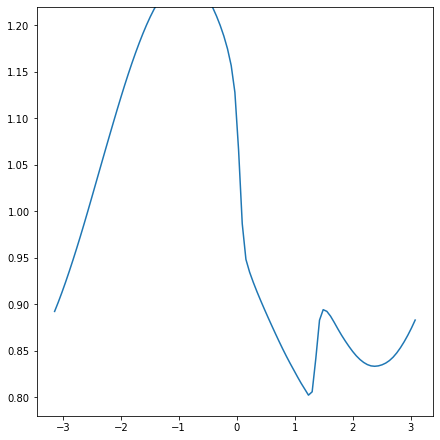

array([[0.89228853, 0.83791864, 3.05018863],
       [0.90225904, 0.85227495, 3.05980436],
       [0.91285569, 0.8673954 , 3.06990947],
       [0.92400418, 0.88318977, 3.08036291],
       [0.93563964, 0.89957969, 3.09104824],
       [0.94771291, 0.91651933, 3.1019344 ],
       [0.9601918 , 0.93400138, 3.11309363],
       [0.97305364, 0.9520401 , 3.12465522],
       [0.98626859, 0.97063579, 3.13671631],
       [0.99978218, 0.98974143, 3.14926712],
       [1.01350992, 1.0092549 , 3.16218071],
       [1.02735061, 1.02904445, 3.17527484],
       [1.04121184, 1.04899399, 3.18840883],
       [1.05503134, 1.06903954, 3.20155503],
       [1.06877887, 1.08917166, 3.21479691],
       [1.08243694, 1.10940071, 3.22825398],
       [1.09597402, 1.12970903, 3.24198467],
       [1.10932855, 1.15002242, 3.25593213],
       [1.1224127 , 1.17021771, 3.26994393],
       [1.13513132, 1.19015774, 3.28384576],
       [1.1474034 , 1.20973033, 3.29751874],
       [1.15917393, 1.22886841, 3.31093367],
       [1.

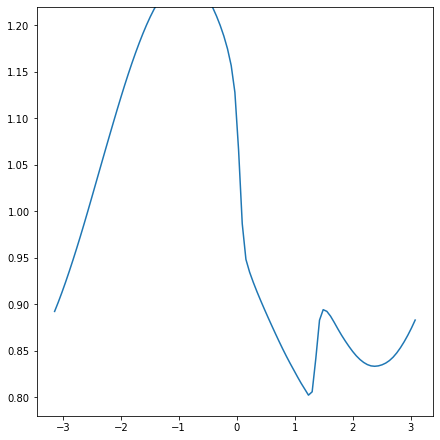

In [48]:
interval=2*np.pi
n_pts=100
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
γ=1.4
CFL=0.5
FinalTime=10
BoundaryCondition=FronteiraPeriodica
ρ=np.sin(x)*0.2+1
u=ρ
p=x-x+1
E=p/(γ-1)+ρ*(u**2)/2

Q=np.stack([ρ,ρ*u,E],axis=1)

Euler1D(Q, γ, Δx, CFL, FinalTime, BoundaryCondition)